# Machine Learning Project- Building a Deep Reinforcement Learning Trading Bot

## - Praharsh Mehrotra (906306085)

In [1]:
# Importing Modules

import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler
import gym
from gym import spaces

from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

import optuna
import gym
import torch
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.utils import obs_as_tensor
import tqdm
import rich
import os
from stable_baselines3.common.utils import get_linear_fn
from stable_baselines3.common.logger import configure
import torch.nn.functional as F

In [2]:
seed_value = 42

In [3]:
# Set random seeds for reproducibility
set_random_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)


In [4]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
stockdata = df['Symbol'].to_list()

full_stock_data = yf.download('AAPL', '1980-01-01',threads=False)
vix_data = yf.download('^VIX', '1980-01-01',threads=False)
spy_data = yf.download('^GSPC', '1980-01-01',threads=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Get the latest price and time
full_stock_data.fillna(method='ffill', inplace=True)
latest_price = full_stock_data['Close']
adj_lat_price = full_stock_data['Close']
volume = full_stock_data['Volume']

# Taking apple stock price
aapl_close = adj_lat_price[['AAPL']]

In [14]:
aapl_close

Ticker,AAPL
Date,
1980-12-12,0.098726
1980-12-15,0.093575
1980-12-16,0.086707
1980-12-17,0.088853
1980-12-18,0.091429
...,...
2025-03-17,214.000000
2025-03-18,212.690002
2025-03-19,215.240005


### Engineered Features

In [15]:
pre_data = aapl_close.copy()

In [16]:
# Features Used

pre_data['mov_avg'] = pre_data['AAPL'].rolling(10).mean()
pre_data['lag_1'] = pre_data['AAPL'].shift(1)
pre_data['lag_2'] = pre_data['AAPL'].shift(2)
pre_data['rsi'] = ta.rsi(pre_data['AAPL'], length=14)
pre_data['vix'] = vix_data['Close']['^VIX']
pre_data['spy'] = spy_data['Close']['^GSPC']
pre_data['volume'] = volume

In [17]:
# Rescaling data since RL models perform better on normalized data

scalar = StandardScaler()
pre_processed_data = scalar.fit_transform(pre_data)


In [18]:
pre_processed_data = pd.DataFrame(pre_processed_data, columns = pre_data.columns, index = pre_data.index)

In [19]:
# Splitting into train and test

train_data,test_data = train_test_split(pre_processed_data, train_size = 0.8, shuffle = False)

In [21]:
train_data.dropna(inplace = True)

In [22]:
train_data

Ticker,AAPL,mov_avg,lag_1,lag_2,rsi,vix,spy,volume
Date,,,,,,,,
1990-01-02,-0.469160,-0.469343,-0.469371,-0.469391,-0.703209,-0.284285,-0.805541,-0.391634
1990-01-03,-0.469126,-0.469305,-0.469099,-0.469305,-0.607379,-0.162856,-0.806254,-0.317515
1990-01-04,-0.469109,-0.469269,-0.469065,-0.469033,-0.557484,-0.031202,-0.808625,-0.277107
1990-01-05,-0.469092,-0.469242,-0.469048,-0.468998,-0.505109,0.082558,-0.811288,-0.570640
1990-01-08,-0.469058,-0.469218,-0.469031,-0.468981,-0.396681,0.101731,-0.810068,-0.635620
...,...,...,...,...,...,...,...,...
2016-04-29,-0.060979,-0.019355,-0.055870,-0.042375,-2.423007,-0.481127,0.503350,-0.119844
2016-05-02,-0.061420,-0.025472,-0.060678,-0.055571,-2.431671,-0.611503,0.515728,-0.363411
2016-05-03,-0.054631,-0.030657,-0.061119,-0.060382,-1.950307,-0.493909,0.501869,-0.259735


### Creating a Custom Trading Environment For Reinforcement Learning

In [23]:
import enum

class Actions(enum.Enum):
    Hold = 0
    Buy = 1
    Sell = 2

In [24]:
class trading_env(gym.Env):
    metadata = {'render_env':'human'}
    
    def __init__(self, 
                data, 
                eng_columns = ['mov_avg','lag_1', 'lag_2', 'rsi', 'vix','spy','volume'],
                starting_balance = 100,
                price_column = 'AAPL',
                sample_days = 30,
                commission_rate = 0.001,
                random_on_reset = True):
        
        
        
        super(trading_env,self).__init__()
        
        self.eng_columns = eng_columns
        self.starting_balance = starting_balance
        self.price_column = price_column
        self.sample_days = sample_days
        self.commission_rate = commission_rate
        self.random_on_reset = random_on_reset
        self.data = data
        
        self.cur_step = sample_days
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low = -np.inf, high = np.inf, shape = (len(self.eng_columns)*self.sample_days + 3,), dtype = np.float64)
        self.reward_range = (-np.inf,np.inf)
        self.cash = starting_balance
        self.shares = 0
    
    def take_action(self, action):
        if action == 1:
            if (self.shares == 0):
                buy_price = self.cur_close_price * (1 + self.commission_rate)
                self.shares = self.cash/buy_price
                self.cash = self.cash - (self.shares * buy_price)
                
                
        elif action == 2:
            if (self.shares > 0):
                sell_price = self.cur_close_price * (1 - self.commission_rate)
                self.cash = self.cash + (self.shares * sell_price)
                
                self.shares = 0

        
    
        

    def step(self, action):
        balance = self.cur_balance
        price = self.cur_close_price
        self.cur_step = self.cur_step + 1
        if self.cur_step == self.total_steps:
            
            self.cur_step = self.sample_days
            
        
        self.take_action(action)
        
        obs = self.next_observation(action)
        
        #if action == 0:
        reward = (self.cur_balance/balance)-(self.cur_close_price/price) #- 1 - 0.5
        #else:
            #reward = (self.cur_balance/balance)- 1 + 0.5
            

        done = self.cur_step >= self.total_steps - 1
        info = {'Date': self.cur_data.index[self.cur_step],
                'Reward' : reward,
                'Action' : Actions(action).name,
                'Shares' : self.shares,
                'Close' : self.cur_close_price,
                'Cash' : self.cash,
                'Total' : self.cur_balance}
        
        if done:
           
            self.reset()
            
        return obs, reward, done, info
                
                
    def next_observation(self, action):
        observation = []
        
        for i in range(self.sample_days, 0, -1):
            observation = np.append(observation, self.cur_indicators.values[self.cur_step - i + 1])
        return (np.append(observation, [self.cash, self.shares * self.cur_close_price , action]))
        
        
    
    def reset(self):
        self.cash = self.starting_balance
        self.shares = 0
        return (self.next_observation(Actions.Hold.value))
    
    
    @property
    def cur_data(self):
        return self.data
    
    @property
    def cur_indicators(self):
        return self.cur_data[self.eng_columns]
    
    @property
    def total_steps(self):
        return len(self.cur_data)
    
    @property    
    def cur_close_price(self):
        return self.cur_data[self.price_column][self.cur_step]
    
    @property
    def cur_balance(self):
        return self.cash + (self.shares * self.cur_close_price)
    
    def seed(self, seed_value):
    # Set the seed for the environment's random number generators
        np.random.seed(seed_value)
        random.seed(seed_value)

    
    

In [25]:
# Set PYTHONHASHSEED for hash-based operations
os.environ["PYTHONHASHSEED"] = "42"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["TORCH_NUM_THREADS"] = "1"

In [26]:
# Initialize environment

env = trading_env(train_data)
env.seed(seed_value)
env.action_space.seed(seed_value)
#env.observation_space.seed(seed_value)

[42]

In [27]:
# Using a GPU
device = torch.device("cuda")

In [28]:
# Learning rate decay function

def lr_schedule(progress_remaining: float) -> float:
    # Linearly decay learning rate from 3e-4 to 1e-5
    return 3e-4 * progress_remaining  # Decrease the learning rate over time

## DQN Model

In [29]:
# Initial Model creation

model = DQN('MlpPolicy',env, learning_rate = lr_schedule, verbose = 1, device = device, exploration_initial_eps  = 1, exploration_final_eps = 0.1, exploration_fraction = 0.5, seed = seed_value, buffer_size=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Python\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "


In [59]:
model = DQN.load('nyse_dqn_model.pt',env=env)
model.save_replay_buffer("replay_buffer.pkl")
model.load_replay_buffer("replay_buffer.pkl")

for i in range(3):
    model.save('nyse_dqn_model.pt')
    model = DQN.load('nyse_dqn_model.pt',env=env)

    tmp_path = "/tmp/sb3_log/"

    #new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])

    
    model.learn(total_timesteps=5000, log_interval=10,progress_bar = True)


    print(i)


C:\Python\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

Output()

0
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

1
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


2


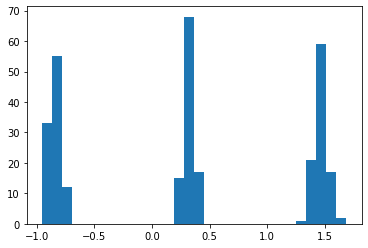

In [60]:
# Import Q values

import torch

# Get Q-values for some sample states
sample_states = []
for i in range(100):
    action = env.action_space.sample()  # Choose random action
    state, reward, done, info = env.step(action)
    sample_states.append(state)  # Append state to sample_states
sample_states = np.array(sample_states)

# Convert sample states to tensor
sample_states_tensor = torch.tensor(sample_states, dtype=torch.float32)

q_values = model.q_net(torch.tensor(sample_states)).detach().numpy()
plt.hist(q_values.flatten(), bins = 30)
plt.show()

In [61]:
# Setting prediction environent seed

env_test = trading_env(test_data)
env_test.seed(seed_value)
env_test.action_space.seed(seed_value)


[42]

In [62]:
# Prediction environment

test_data_denorm = pd.DataFrame(scalar.inverse_transform(test_data), columns = test_data.columns, index = test_data.index)
env_denorm_test = trading_env(test_data_denorm)
env_denorm_test.seed(seed_value)
env_denorm_test.action_space.seed(seed_value)


[42]

In [63]:
# DQN Model Testing

recs = []

#model.set_env(DummyVecEnv([lambda:env_test]))
model.set_env(env_test)
obs = env_test.reset()
done= False
    
rec = pd.DataFrame()

while (done == False):
    
    action, _ = model.predict(obs)
    
    
    obs, _, done, info = env_test.step(action)
    
    obs_2, _2, done_2, info_2 = env_denorm_test.step(action)
    
    rec = pd.concat([rec, pd.DataFrame(info_2, index = [info_2['Date']])])
    

    recs.append(rec)
    
    

C:\Python\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


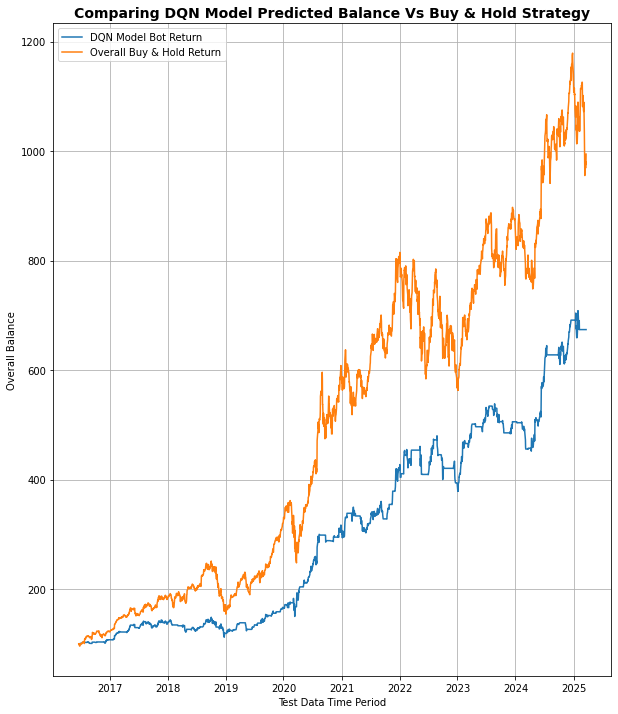

In [64]:
# Result Plot

plt.figure(figsize = (10,12))

plt.plot(rec['Total'], label = 'DQN Model Bot Return')
plt.plot((100/rec['Close'][0])*rec['Close'], label = 'Overall Buy & Hold Return')
plt.xlabel('Test Data Time Period')
plt.ylabel('Overall Balance')
plt.title('Comparing DQN Model Predicted Balance Vs Buy & Hold Strategy', fontsize = 14, fontweight="bold")

plt.legend()
plt.grid()
plt.show()

In [65]:
rec.groupby("Action").count()

,Date,Reward,Shares,Close,Cash,Total
Action,,,,,,
Buy,198,198,198,198,198,198
Hold,1778,1778,1778,1778,1778,1778
Sell,225,225,225,225,225,225


### PPO Model Algorithm

In [66]:
# Initializing model

model_ppo =  PPO('MlpPolicy',env, learning_rate = lr_schedule, verbose = 1, device = device, seed = seed_value)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Python\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "


In [67]:
# Saving the Model

model_ppo.save('nyse_ppo_model.pt')
model_ppo = PPO.load('nyse_ppo_model.pt',env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [68]:
# Training the model

for i in range(3):
    model_ppo.save('nyse_ppo_model.pt')
    model_ppo = PPO.load('nyse_ppo_model.pt',env=env)
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_ppo.learn(total_timesteps=5000, log_interval=10,progress_bar = True)

    print(i)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /tmp/sb3_log/


Output()

0
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /tmp/sb3_log/


Output()

1
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /tmp/sb3_log/


Output()

2


In [69]:
# Setting environent seed

env_test = trading_env(test_data)
env.seed(42)
env.action_space.seed(42)
env.observation_space.seed(42)


[42]

In [70]:
# Prediction environment

test_data_denorm = pd.DataFrame(scalar.inverse_transform(test_data), columns = test_data.columns, index = test_data.index)
env_denorm_test = trading_env(test_data_denorm)
env_denorm_test.seed(42)
env_denorm_test.action_space.seed(42)
env_denorm_test.observation_space.seed(42)

[42]

In [71]:
recs_ppo = []

#model.set_env(DummyVecEnv([lambda:env_test]))
model_ppo.set_env(env_test)
obs = env_test.reset()
done= False
    
rec_ppo = pd.DataFrame()

while (done == False):
    
    action, _ = model_ppo.predict(obs)
    
    
    obs, _, done, info = env_test.step(action)
    
    obs_2, _2, done_2, info_2 = env_denorm_test.step(action)
    
    rec_ppo = pd.concat([rec_ppo, pd.DataFrame(info_2, index = [info_2['Date']])])
    

    recs_ppo.append(rec_ppo)
    

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Python\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "


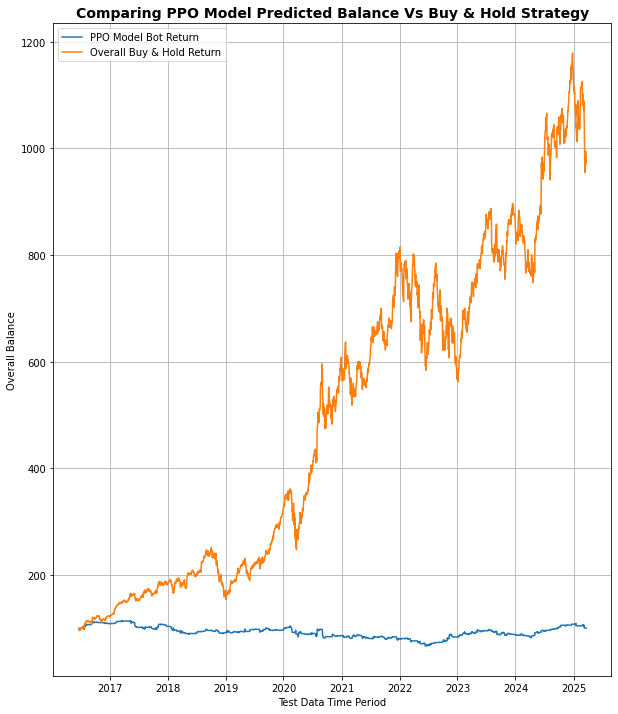

In [72]:
plt.figure(figsize = (10,12))

plt.plot(rec_ppo['Total'], label = 'PPO Model Bot Return')
plt.plot((100/rec_ppo['Close'][0])*rec_ppo['Close'], label = 'Overall Buy & Hold Return')
plt.xlabel('Test Data Time Period')
plt.ylabel('Overall Balance')
plt.title('Comparing PPO Model Predicted Balance Vs Buy & Hold Strategy', fontsize = 14, fontweight="bold")

plt.legend()
plt.grid()
plt.show()

In [73]:
rec_ppo

,Date,Reward,Action,Shares,Close,Cash,Total
2016-06-21,2016-06-21,-0.008518,Sell,0.000000,21.949245,100.000000,100.000000
2016-06-22,2016-06-22,0.003753,Hold,0.000000,21.866861,100.000000,100.000000
2016-06-23,2016-06-23,-0.006755,Buy,4.542415,21.992729,0.000000,99.900100
2016-06-24,2016-06-24,-0.000972,Sell,0.000000,21.374825,96.996227,96.996227
2016-06-27,2016-06-27,0.013562,Buy,4.600325,21.063581,0.000000,96.899328
...,...,...,...,...,...,...,...
2025-03-17,2025-03-17,-0.002389,Sell,0.000000,214.000000,100.762675,100.762675
2025-03-18,2025-03-18,0.006121,Sell,0.000000,212.690002,100.762675,100.762675
2025-03-19,2025-03-19,-0.011989,Sell,0.000000,215.240005,100.762675,100.762675
2025-03-20,2025-03-20,0.005296,Hold,0.000000,214.100006,100.762675,100.762675


In [74]:
rec_ppo.groupby("Action").count()

,Date,Reward,Shares,Close,Cash,Total
Action,,,,,,
Buy,436,436,436,436,436,436
Hold,631,631,631,631,631,631
Sell,1134,1134,1134,1134,1134,1134


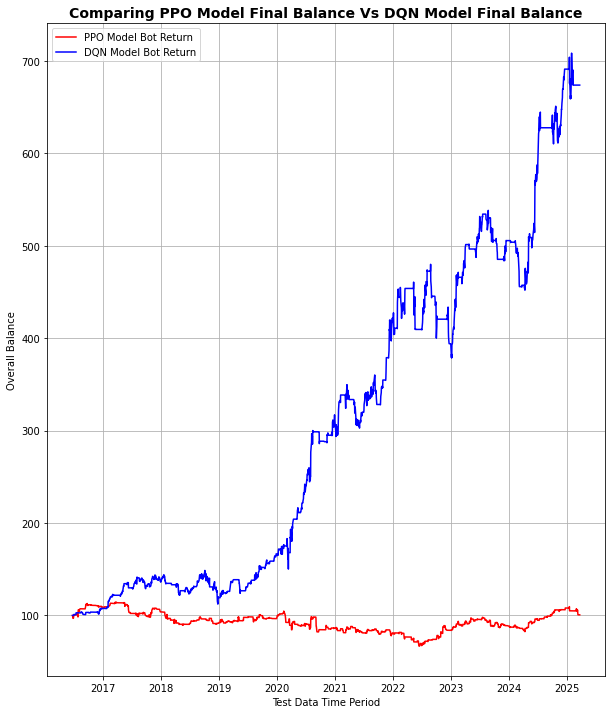

In [75]:
# Comparing PPO vs DQN Results Plot

plt.figure(figsize = (10,12))

plt.plot(rec_ppo['Total'], label = 'PPO Model Bot Return', color = 'red')
plt.plot(rec['Total'], label = 'DQN Model Bot Return', color = 'blue')
plt.xlabel('Test Data Time Period')
plt.ylabel('Overall Balance')
plt.title('Comparing PPO Model Final Balance Vs DQN Model Final Balance', fontsize = 14, fontweight="bold")

plt.legend()
plt.grid()
plt.show()

### Model Evaluation And Comparison

### 1. Total Rewards And Average Rewards Per Step By Test Data

Overall performance in terms of rewards accumulated

#### DQN Model

In [39]:
print(rec['Reward'].describe())
print(f'Total Rewards: {rec["Reward"].sum():.2f}')


count    2201.000000
mean       -0.307569
std         0.393681
min        -0.579092
25%        -0.500000
50%        -0.500000
75%        -0.483412
max         0.600326
Name: Reward, dtype: float64
Total Rewards: -676.96


#### PPO Model

In [40]:
print(rec_ppo['Reward'].describe())
print(f'Total Rewards: {rec_ppo["Reward"].sum():.2f}')


count    2201.000000
mean       -0.287966
std         0.408253
min        -0.580061
25%        -0.500000
50%        -0.500000
75%        -0.478992
max         0.599225
Name: Reward, dtype: float64
Total Rewards: -633.81


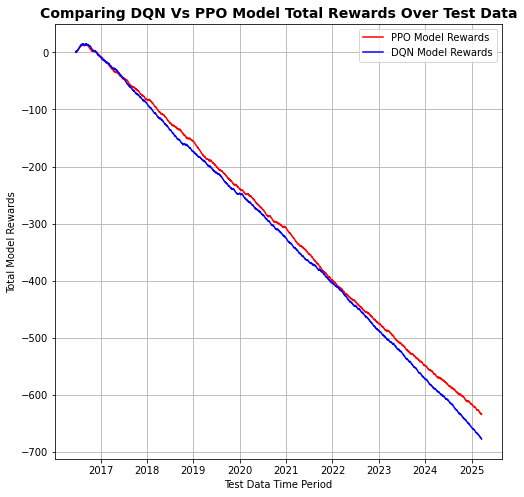

In [41]:
# Plotting total Model rewards
plt.figure(figsize = (8,8))

plt.plot(np.cumsum(rec_ppo["Reward"]), label = 'PPO Model Rewards', color = 'red')
plt.plot(np.cumsum(rec["Reward"]), label = 'DQN Model Rewards', color = 'blue')
plt.xlabel('Test Data Time Period')
plt.ylabel('Total Model Rewards')
plt.title('Comparing DQN Vs PPO Model Total Rewards Over Test Data', fontsize = 14, fontweight="bold")
plt.legend()
plt.grid()
plt.show()

### 2. Learning Efficiency (Reward Per Timestep)

Comparing DQN Vs PPO Model

In [42]:
def learning_efficiency(env, model, num_episodes = 10):
    efficiency = []
    total_rewards = 0
    total_steps = 0
    
    
    for i in range(num_episodes):
        
        # Set all relevant seeds
        random.seed(seed_value)                
        np.random.seed(seed_value)             
        torch.manual_seed(seed_value)         
        torch.cuda.manual_seed_all(seed_value) 
        set_random_seed(seed_value)            
        
        env.seed(seed_value)
        env.action_space.seed(seed_value)
        
        obs = env.reset()
        # Set environment seed

        done = False
    
        while not done:
            action = model.predict(obs)[0]
            obs,reward, done, info = env.step(action)
            total_rewards += reward
            total_steps += 1
        efficiency.append(total_rewards/total_steps)
        print(i)
    
    total_efficiency = total_rewards/total_steps
    
    return efficiency, total_efficiency

In [43]:
# Set all relevant seeds
random.seed(seed_value)                
np.random.seed(seed_value)             
torch.manual_seed(seed_value)         
torch.cuda.manual_seed_all(seed_value) 
set_random_seed(seed_value)            
        
env_test.seed(seed_value)
env_test.action_space.seed(seed_value)

[42]

In [44]:
# Learning Efficiency Parameters

dqn_ep_efficiency, dqn_total_efficiency = learning_efficiency(env_test, model)
ppo_ep_efficiency, ppo_total_efficiency = learning_efficiency(env_test, model_ppo)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


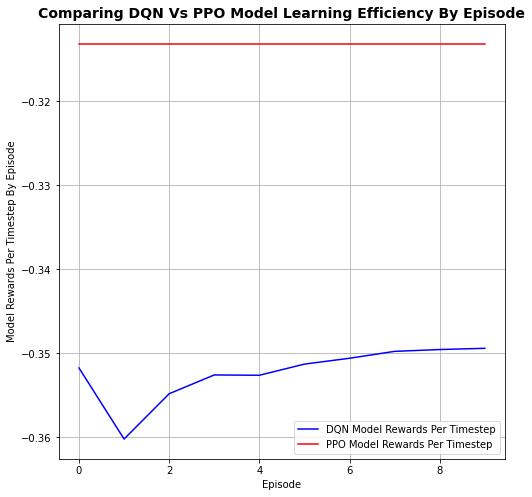

In [45]:
# Model Learning Efficiency

plt.figure(figsize = (8,8))

plt.plot(dqn_ep_efficiency, label = 'DQN Model Rewards Per Timestep', color = 'blue')
plt.plot(ppo_ep_efficiency, label = 'PPO Model Rewards Per Timestep', color = 'red')
plt.xlabel('Episode')
plt.ylabel('Model Rewards Per Timestep By Episode')
plt.title('Comparing DQN Vs PPO Model Learning Efficiency By Episode', fontsize = 14, fontweight="bold")
plt.legend()
plt.grid()
plt.show()

### 3. Exploration vs Exploitation (Model Stability)

Calculating PPO Model Entropy And DQN Model Epsilon and comparing

#### For PPO Model

In [46]:
def exploration_entropy(env, model, num_episodes = 10):
    entropies = []
    episode_entropies = []
    
    for i in range(num_episodes):
        
        # Set all relevant seeds
        random.seed(seed_value)                
        np.random.seed(seed_value)             
        torch.manual_seed(seed_value)         
        torch.cuda.manual_seed_all(seed_value) 
        set_random_seed(seed_value)            
        
        env.seed(seed_value)
        env.action_space.seed(seed_value)
        

        obs = env.reset()
        done = False
        
        while not done:
            obs = np.asarray(obs, dtype=np.float32)  # Convert to proper dtype
            obs_tensor = obs_as_tensor(obs, 'cpu').unsqueeze(0) 
            dist = model.policy.get_distribution(obs_tensor)
            entropy = dist.entropy().item()
            entropies.append(entropy)
            action = dist.sample().cpu().numpy()
            obs, _, done,info = env.step(action)
        
        # mean entropy at the end of each episode
        
        episode_entropies.append(np.mean(entropies))
        
        # Check which episode is running
        print(i)
            
    return entropies,episode_entropies, np.mean(entropies)

In [47]:
# Set all relevant seeds
random.seed(seed_value)                
np.random.seed(seed_value)             
torch.manual_seed(seed_value)         
torch.cuda.manual_seed_all(seed_value) 
set_random_seed(seed_value)            
        
env_test.seed(seed_value)
env_test.action_space.seed(seed_value)

[42]

In [48]:
ppo_model_entropies, ppo_model_episode_end_entropies, ppo_model_avg_entropy = exploration_entropy(env_test,model_ppo) 

C:\Python\lib\site-packages\numpy\core\fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


0
1
2
3
4
5
6
7
8
9


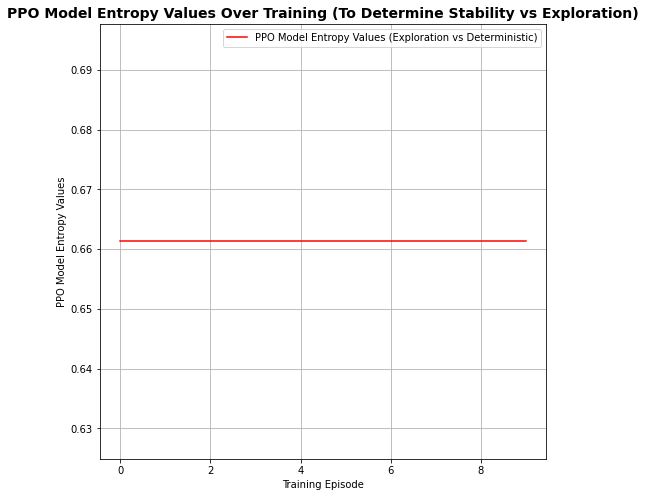

In [49]:
# Plotting


plt.figure(figsize = (8,8))

plt.plot(ppo_model_episode_end_entropies, label = 'PPO Model Entropy Values (Exploration vs Deterministic)', color = 'red')

plt.xlabel('Training Episode')
plt.ylabel('PPO Model Entropy Values')
plt.title('PPO Model Entropy Values Over Training (To Determine Stability vs Exploration)', fontsize = 14, fontweight="bold")
plt.legend()
plt.grid()
plt.show()

#### DQN Model

In [50]:
# DQN model Parameters specified

exploration_initial_eps  = 1
exploration_final_eps = 0.1
exploration_fraction = 0.5

# Getting Epsilon values
epsilon_fn = get_linear_fn(exploration_initial_eps, exploration_final_eps, exploration_fraction)

In [51]:
# Calculating Epsilon values over Training Period

epsilon_val = []
for i in range(0,101):
    epsilon_val.append(epsilon_fn(1 - (i/100)))
    


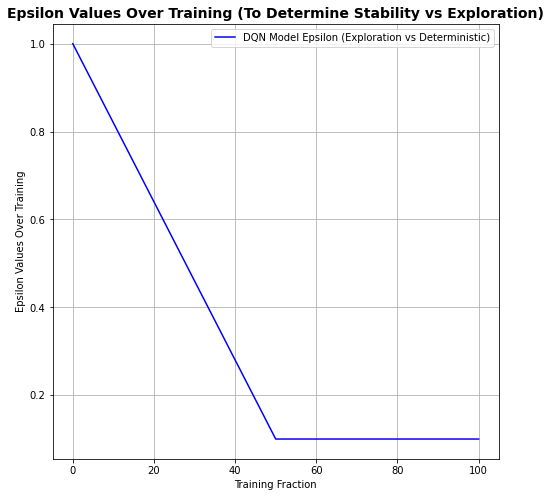

In [52]:
# Epsilon values plotting

plt.figure(figsize = (8,8))

plt.plot(epsilon_val, label = 'DQN Model Epsilon (Exploration vs Deterministic)', color = 'blue')

plt.xlabel('Training Fraction')
plt.ylabel('Epsilon Values Over Training')
plt.title('Epsilon Values Over Training (To Determine Stability vs Exploration)', fontsize = 14, fontweight="bold")
plt.legend()
plt.grid()
plt.show()

### 4. Model Stability

Comparing DQN And PPO Model Stability Using Standard Deviation Of Rewards Per Timestep

In [53]:
def model_stability(env, model, num_episodes = 10):
    rewards = []
    reward_std = []
    for i in range(num_episodes):
        


        
        # Set all relevant seeds
        random.seed(seed_value)                
        np.random.seed(seed_value)             
        torch.manual_seed(seed_value)         
        torch.cuda.manual_seed_all(seed_value) 
        set_random_seed(seed_value)            
        
        env.seed(seed_value)
        env.action_space.seed(seed_value)
        
        obs = env.reset()
        done = False
        
        while not done:
            
            action = model.predict(obs)[0]
            obs, reward, done, info = env.step(action)
            rewards.append(reward)
        reward_std.append(np.std(rewards))
        
        print(i)
        
    return reward_std
            
        

In [54]:
# Set all relevant seeds
random.seed(seed_value)                
np.random.seed(seed_value)             
torch.manual_seed(seed_value)         
torch.cuda.manual_seed_all(seed_value) 
set_random_seed(seed_value)            
        
env_test.seed(seed_value)
env_test.action_space.seed(seed_value)

[42]

In [55]:
# Calculating Model stability

dqn_model_std_by_ep = model_stability(env_test, model)
ppo_model_std_by_ep = model_stability(env_test, model_ppo)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


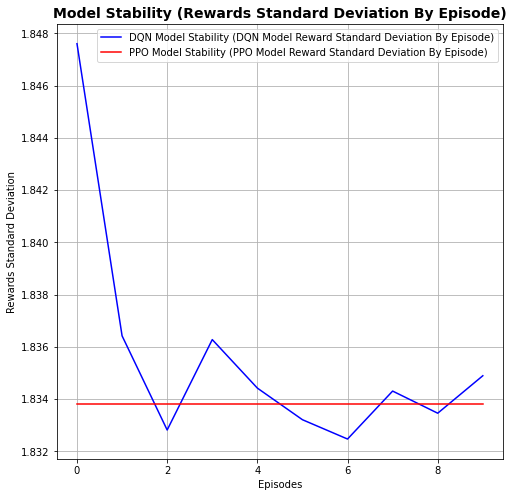

In [56]:
# Plotting Model Std

plt.figure(figsize = (8,8))

plt.plot(dqn_model_std_by_ep, label = 'DQN Model Stability (DQN Model Reward Standard Deviation By Episode)', color = 'blue')
plt.plot(ppo_model_std_by_ep, label = 'PPO Model Stability (PPO Model Reward Standard Deviation By Episode)', color = 'red')

plt.xlabel('Episodes')
plt.ylabel('Rewards Standard Deviation')
plt.title('Model Stability (Rewards Standard Deviation By Episode)', fontsize = 14, fontweight="bold")

plt.legend()
plt.grid()
plt.show()

### 5. Model Testing Loss

Comparing MSE Between DQN And PPO Model

#### DQN Loss

In [57]:
def dqn_loss(env, model, num_episodes = 10):
    losses = []

    
    for i in range(num_episodes):
        loss_temp = []
        # Set all relevant seeds
        random.seed(seed_value)                
        np.random.seed(seed_value)             
        torch.manual_seed(seed_value)         
        torch.cuda.manual_seed_all(seed_value) 
        set_random_seed(seed_value)            
        
        env.seed(seed_value)
        env.action_space.seed(seed_value)
        
        obs = env.reset()
        done = False
        
        while not done:
            
            obs = np.asarray(obs, dtype=np.float32)  # Convert to proper dtype
            obs_tensor = obs_as_tensor(obs, 'cpu').unsqueeze(0)
            q_values = model.q_net(obs_tensor)
            action = torch.argmax(q_values, dim=1).cpu().numpy()
            
            obs, reward, done, info = env.step(action)
            
            target_q_value = reward
            loss = F.mse_loss(q_values[0, action], torch.tensor([target_q_value]))
            loss = np.sqrt(loss.item())/abs(target_q_value)                 
            loss_temp.append(loss)
                              
        losses.append(np.mean(loss_temp))
        
        print(i)
            
    return losses                     

In [58]:
# Calculating Q Value MSE Loss

dqn_model_loss_percent = dqn_loss(env_test, model)

0
1
2
3
4
5
6
7
8
9


#### PPO Model

In [59]:
# PPO MSE Loss

def ppo_loss(env, model, num_episodes = 10):
    losses = []
    
    for i in range(num_episodes):
        loss_temp = []
        
        # Set all relevant seeds
        random.seed(seed_value)                
        np.random.seed(seed_value)             
        torch.manual_seed(seed_value)         
        torch.cuda.manual_seed_all(seed_value) 
        set_random_seed(seed_value)            
        
        env.seed(seed_value)
        env.action_space.seed(seed_value)
        
        obs = env.reset()
        done = False
        
        while not done:
            obs = np.asarray(obs, dtype = np.float32)
            obs_tensor = obs_as_tensor(obs, 'cpu').unsqueeze(0)
            dist = model.policy.get_distribution(obs_tensor)
            value = model.policy.predict_values(obs_tensor)
            
            action = model.predict(obs)[0]
            obs, reward, done, info = env.step(action)
            
            # PPO Loss
            value_loss = F.mse_loss(value, torch.tensor([reward]))
            
            value_loss = float(np.sqrt(value_loss.item())/abs(value))
            
            loss_temp.append(value_loss)
            

        losses.append(np.mean(loss_temp))
        
        print(i)
        
    return losses
        

In [60]:
# Calculating MSE Loss For PPO

ppo_model_loss_percent = ppo_loss(env_test, model_ppo)

C:\Python\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


0
1
2
3
4
5
6
7
8
9


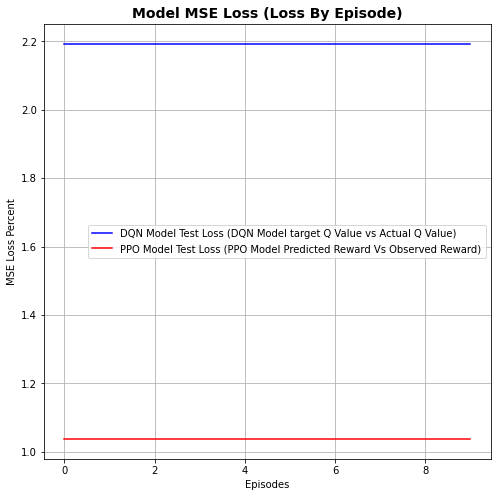

In [64]:
# Plotting Model Test MSE Loss

plt.figure(figsize = (8,8))

plt.plot(dqn_model_loss_percent, label = 'DQN Model Test Loss (DQN Model target Q Value vs Actual Q Value)', color = 'blue')
plt.plot(ppo_model_loss_percent, label = 'PPO Model Test Loss (PPO Model Predicted Reward Vs Observed Reward)', color = 'red')

plt.xlabel('Episodes')
plt.ylabel('MSE Loss Percent')
plt.title('Model MSE Loss (Loss By Episode)', fontsize = 14, fontweight="bold")
plt.legend()
plt.grid()
plt.show()